In [1]:
from data_reader import Vocabulary, HWDBDatasetHelper, LMDBReader

# your path to data
train_path = r'/DATA/ichuviliaeva/ocr_data/train.lmdb'
test_path = r'/DATA/ichuviliaeva/ocr_data/test.lmdb'
gt_path = './gt.txt'

In [2]:
import cv2
import numpy as np
import torchvision
import wandb

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_reader = LMDBReader(train_path)
train_reader.open()
train_helper = HWDBDatasetHelper(train_reader)

In [4]:
train_helper, val_helper = train_helper.train_val_split()

In [5]:
train_helper.size(), val_helper.size()

(2578433, 644609)

In [6]:
import torch

from torch.utils.data import Dataset, DataLoader
from torch import nn

class HWDBDataset(Dataset):
    def __init__(self, helper: HWDBDatasetHelper):
        self.helper = helper
    
    def __len__(self):
        return self.helper.size()
    
    def __getitem__(self, idx):
        img, label = self.helper.get_item(idx)
        return torch.FloatTensor((cv2.resize(img, (32, 32)) - 127.5) / 255.)[None, ...], label

In [7]:
torch.manual_seed(42)

In [8]:
train_dataset = HWDBDataset(train_helper)
val_dataset = HWDBDataset(val_helper)

In [9]:
from task2pack.utils.train import show_train_plots, train_new

In [10]:
model = torchvision.models.resnet34(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, train_helper.vocabulary.num_classes())

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
model_name = 'ResNet34'

train_dataloader_config = {
    'batch_size': 512,
    'shuffle': True,
    'drop_last': True,
    'num_workers': 8,
}

test_dataloader_config = {
    'batch_size': 2048,
    'shuffle': False,
    'num_workers': 8,
}

training_config = {
    'lr': 1e-3,
    'epochs': 15,
    'milestones': [25, 50, 75],
    'gamma': 0.7,
}

device = 'cuda:2'
criterion = torch.nn.CrossEntropyLoss()

wandb.init(
    project='ocr task 2',
    name='{} {} epochs with lr={} no augment'.format(model_name, training_config['epochs'], training_config['lr']),
    config={
        'train_dataloader_config': train_dataloader_config,
        'test_dataloader_config': test_dataloader_config,
        'training_config': training_config,

    "architecture": model_name,
    "dataset": "CASIA Offline Chinese Handwriting",
    "criterion": "Cross Entropy Loss",
    "optimizer": "Adam",
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vashchilkoav. Use `wandb login --relogin` to force relogin


In [12]:
train_dataset[0][0].shape

torch.Size([1, 32, 32])

In [13]:
train_losses, test_losses, trained_model = train_new(
    train_dataset=train_dataset,
    test_dataset=val_dataset,
    model=model, 
    criterion=criterion, 
    train_dataloader_kwargs=train_dataloader_config,
    test_dataloader_kwargs=test_dataloader_config,
    training_kwargs=training_config,
    device=device,
    wandb_instance=wandb
)

Initial val loss: 0.004818021796841947
Epoch 1:
Train loss: 0.003318494446454554
Epoch 2:
Train loss: 0.0008074368173448409
Epoch 3:
Train loss: 0.0005756397596859412
Epoch 4:
Train loss: 0.00044718459440901923
Epoch 5:
Val loss: 0.0001680872888870232
Train loss: 0.0003615527535812654
Epoch 6:
Train loss: 0.00029749782547221416
Epoch 7:
Train loss: 0.00025056467621473817
Epoch 8:
Train loss: 0.00021306805822259535
Epoch 9:
Train loss: 0.00018252091687903258
Epoch 10:
Val loss: 0.00017198128266359826
Train loss: 0.00015913158258936276
Epoch 11:
Train loss: 0.00013922007505729795
Epoch 12:
Train loss: 0.00012399718803788993
Epoch 13:
Train loss: 0.00011186547098826735
Epoch 14:
Train loss: 0.00010147429037332266
Epoch 15:
Val loss: 0.00019970957721381652
Train loss: 9.279135422163174e-05


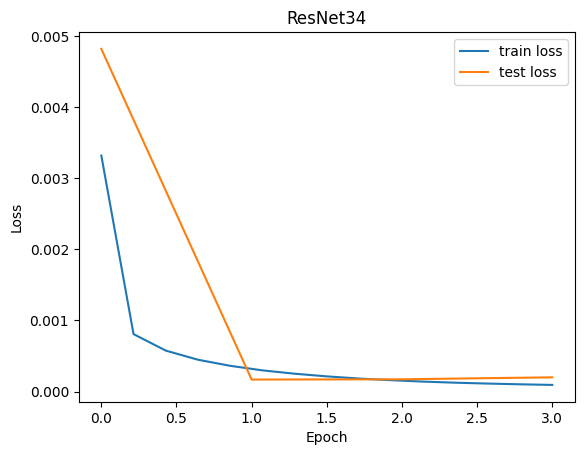

In [14]:
show_train_plots(train_losses, test_losses, 'ResNet34')

In [18]:
from course_ocr_t2.evaluate import evaluate
from tqdm import tqdm

test_path = r'/DATA/ichuviliaeva/ocr_data/test.lmdb'
pred_path = './pred.txt'

test_reader = LMDBReader(test_path)
test_reader.open()
test_helper = HWDBDatasetHelper(test_reader, prefix='Test')

test_dataset = HWDBDataset(test_helper)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False, num_workers=8)

preds = []
trained_model.eval()
with torch.no_grad():
    for X, _ in tqdm(test_loader):
        logits = trained_model(X.to(torch.float32).to(device))
        classes = torch.argmax(logits, dim=1).cpu().numpy()
        preds.extend(classes)
    
with open(pred_path, 'w') as f_pred:
    for idx, pred in enumerate(preds):
        name = test_helper.namelist[idx]
        cls = train_helper.vocabulary.class_by_index(pred)
        print(name, cls, file=f_pred)
        
test_accuracy = evaluate('./gt.txt', './pred.txt')
wandb.run.summary['test_accuracy'] = test_accuracy

torch.save(trained_model.state_dict(), './model.pth')
wandb.save('./model.pth')
wandb.save('./pred.txt')

wandb.finish()

100%|█████████████████████████████████████████████████████████████████████████████████| 380/380 [00:36<00:00, 10.45it/s]


lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,0.001
test_accuracy,0.8932
